K-Means

In [1]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
%run silhouette_plotter.py

In [118]:
sql = '''
SELECT *  FROM `eth-tokens.alldata.clean_with_balances_tokens_500k` LIMIT 100000
'''

df = client.query(sql).to_dataframe()

In [119]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [120]:
#number of PCA features is full reconstruction, for now
num_features = data.shape[1]
num_clusters = 4

In [121]:
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)

cl.fit(results)



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [122]:
#get centroids
c = cl.cluster_centers_
#transform back to real numbers
medoids = scale.inverse_transform(pca.inverse_transform(c))
pd.DataFrame(medoids, columns = data.columns)

,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,avg_eth_recd,total_usd_recd,avg_usd_recd,...,monthly_outgoing_txns,monthly_incoming_txns,monthly_eth_sent,monthly_usd_sent,monthly_eth_recd,monthly_usd_recd,contracts_created,contract_txns_sent,num_tokens_used,eth_balance
0,5.132158e+01,5.592295e+01,4.298779e+02,14.603119,1.782746e+05,6.073268e+03,5.374352e+02,37.900881,2.200220e+05,1.394047e+04,...,5.160165,5.706921,4.236103e+01,1.636922e+04,5.823197e+01,2.186898e+04,2.140471e+00,2.068762e+01,8.436336,112.360293
1,1.539893e+06,4.642263e+06,3.403855e+07,22.104492,2.047549e+10,1.329670e+04,3.440410e+07,7.411063,2.071501e+10,4.462266e+03,...,96243.312500,290141.437500,2.127410e+06,1.279718e+09,2.150257e+06,1.294688e+09,-2.568612e-12,9.902610e-09,519.000000,299076.571854
2,5.286761e+06,2.040500e+03,1.538120e+06,0.287512,7.666102e+08,1.431547e+02,3.558464e+03,8.945928,1.311783e+06,5.049544e+03,...,309643.527778,113.468750,8.961882e+04,4.464704e+07,1.994426e+02,7.390203e+04,2.150000e+01,3.197535e+05,69.500000,7082.579830
3,1.762741e+04,2.773614e+04,6.682671e+05,3964.708275,1.888975e+08,1.623509e+06,6.367896e+05,18676.034817,1.955548e+08,6.599036e+06,...,1237.855569,1654.445122,3.773111e+04,1.207199e+07,4.292546e+04,1.482699e+07,2.222222e-02,3.214444e+02,37.844444,99116.864164


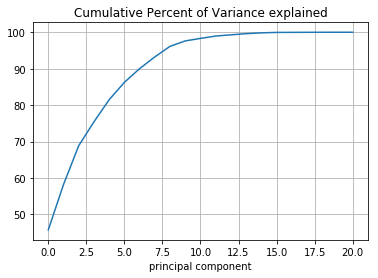

In [123]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

In [124]:
#elbow method


Text(0.5,1,'Calinski Harabaz Scores')

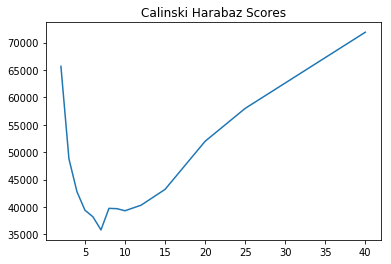

In [125]:
#scoring metric?
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [2, 3,4,5,6,7,8,9,10,12,15,20,25, 40]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

Text(0,0.5,'within cluster sum of squares')

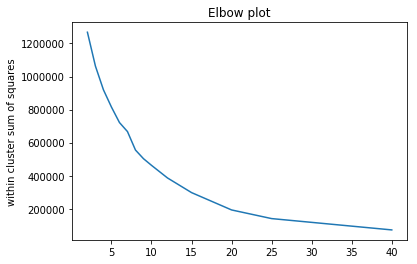

In [126]:
plt.plot(clusters,inertias)
plt.title('Elbow plot')
plt.ylabel('within cluster sum of squares')

In [127]:
#optmal number of clusters is around 15
cl = KMeans(15)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [128]:
#outlier removal


def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
    return np.vstack(new_results), np.array(new_labels)


In [129]:
thresholds = np.linspace(.3,3, 20)

test = [remove_outliers(results, cl,t) for t in thresholds]

scores= []
for (res, labels) in test:
    
    score = ch_score(res, labels)
    scores.append(score)

Text(0.5,1,'Calinski Harabaz Scores as std threshold changes')

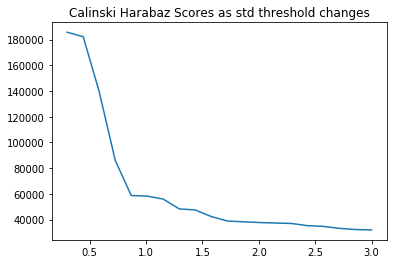

In [130]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [131]:
#empirical best threshold .75 stdev
newresults, labels = remove_outliers(results, cl,.75)

In [132]:
X=newresults
range_n_clusters = [15]
if len(newresults) <20000:
    silhouette_plotter(X, range_n_clusters)

(-15, 10)

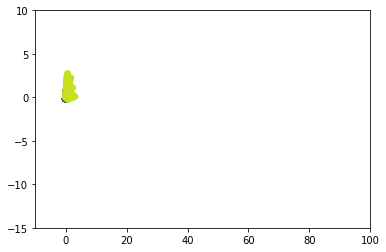

In [133]:

plt.scatter(newresults[:,0],newresults[:,1],c=labels)
plt.xlim(-10,100)
plt.ylim(-15,10)

(-15, 10)

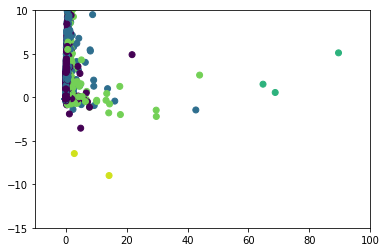

In [134]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
plt.xlim(-10,100)
plt.ylim(-15,10)

In [135]:
#recluster after changes
cl = KMeans(15).fit(results)
newcl = KMeans(15).fit(newresults)

In [136]:
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

In [137]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

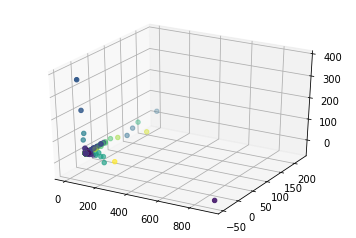

In [138]:

# plt.scatter(newresults[:,0],newresults[:,1],c=newcl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-15,10)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)

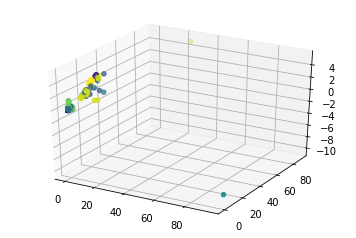

In [139]:
# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)
# ax.set_xlim3d(-1,1)
# ax.set_ylim3d(-3,3)
# ax.view_init(elev=-0, azim=90)
# for ii in range(10,360,10):
#     ax.view_init(elev=10, azim=ii)
#     fig.savefig("movie/movie{}.png".format(ii))

In [140]:
c = cl.cluster_centers_
#transform back to real numbers
centroids = scale.inverse_transform(pca.inverse_transform(c))
df_summary = pd.DataFrame(centroids, columns = data.columns)

In [141]:
cluster_sizes = pd.Series(cl.labels_).value_counts()
df_summary['cluster_size'] = cluster_sizes

In [142]:
df_summary.sort_values('cluster_size', ascending=False, axis=0, inplace=True)

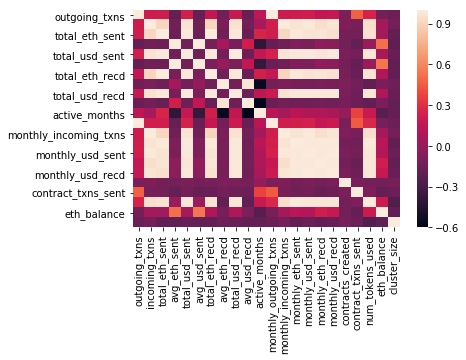

In [143]:
import seaborn as sns
sns.heatmap(df_summary.corr())

In [144]:
arr = df_summary.values

In [145]:
arr.shape

(15, 22)

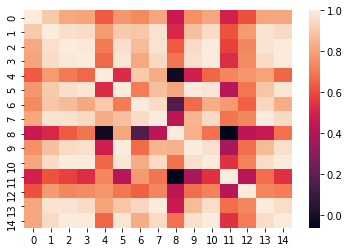

In [146]:
sns.heatmap(np.corrcoef(arr, rowvar=True))

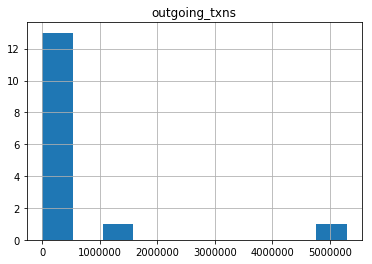

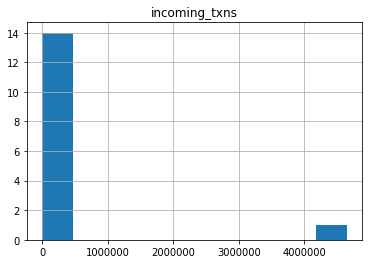

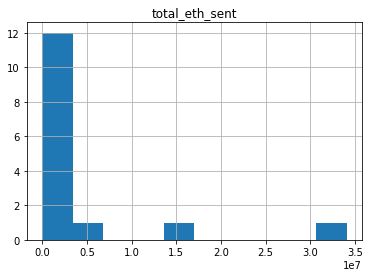

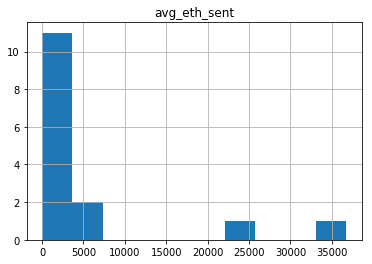

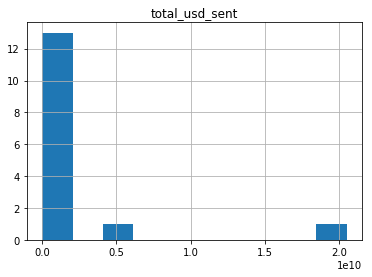

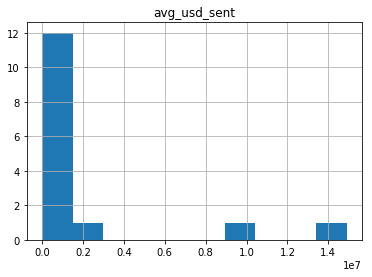

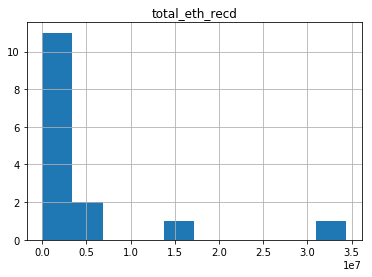

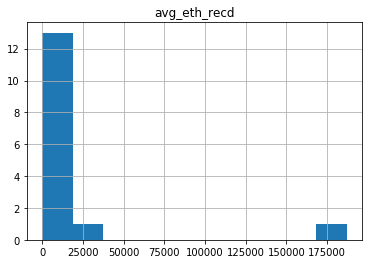

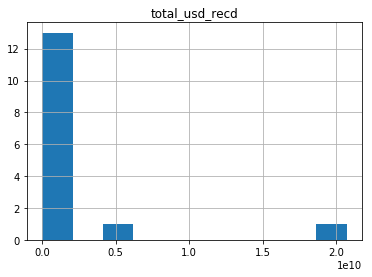

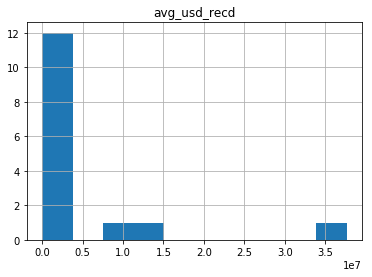

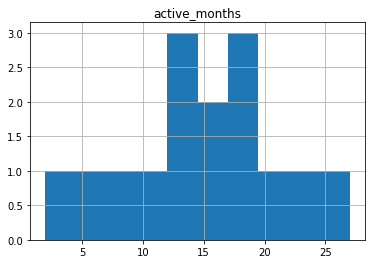

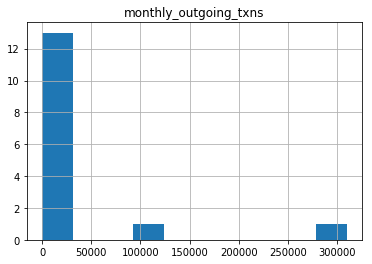

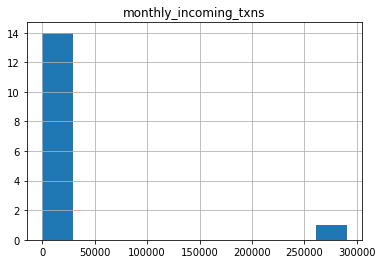

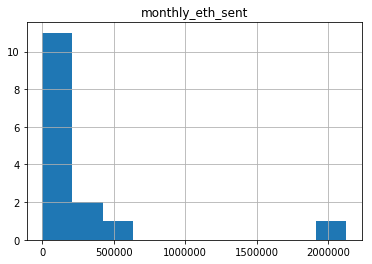

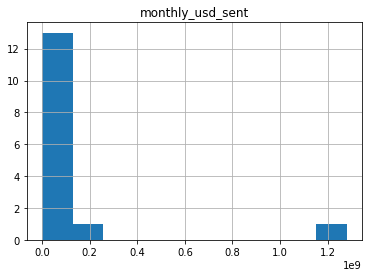

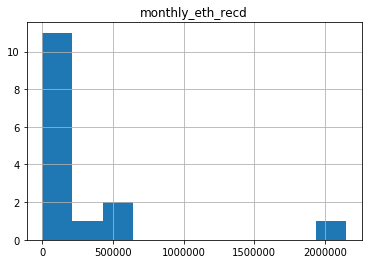

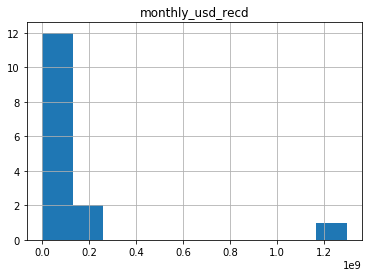

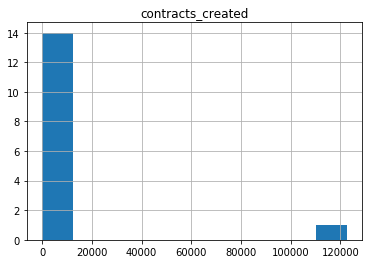

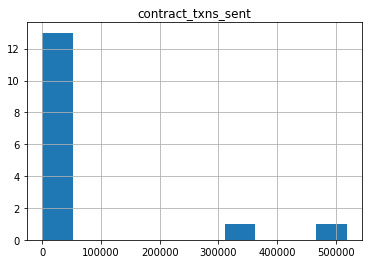

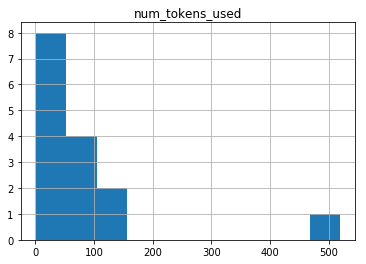

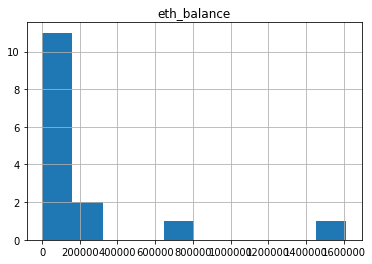

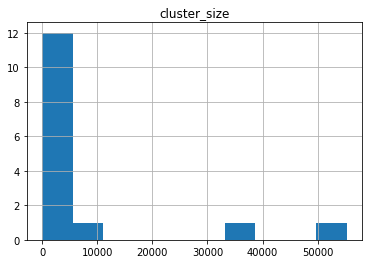

In [147]:
for col in df_summary.columns:
    df_summary[col].hist()
    plt.title(col)
    plt.show()

In [148]:
p = PCA(n_components=3)

In [149]:
vectors = p.fit_transform(arr[:8,:])

In [150]:

xs = vectors[:,0]
ys = vectors[:,1]
zs = vectors[:,2]

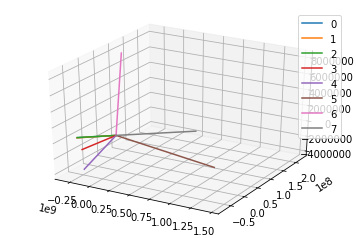

In [151]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
    ax.plot([0,x], [0,y],[0,z], label=i)
plt.legend()